In [19]:
import math
from functools import cache

import numpy as np

In [20]:
def binomial(n, k):
    result = 1
    for i in range(1, k+1):
        result *= n - i + 1
        result /= i
    return result


def prob(n, k, p):
    return p**k * (1-p)**(n-k) * binomial(n, k)


@cache
def probge(n, k, p):
    return sum(prob(n, i, p) for i in range(k, n+1))

In [21]:
def safe_percentage_malicious_validators(kp, e=None):
    '''
    Given a SC majority we want to see confirming a block, we can
    compute how many malicious validators (as a percentage) we can
    tolerate as having a negligible chance of corruption.

    This function approximates the following inequation:
    sum(
        (p^k * (1-p)^(n-k) * binomial(n, k))
        for k in range(342, 512+1)
    ) < 2^(-80).

    If you can compute this analytically, please drop a comment.
    '''
    e = e or 2**(-80)
    k = math.ceil(512 * kp)
    
    def bounds():
        a = None
        for b in np.linspace(0, 1, 2**10):
            cond = probge(512, k, b) < e
            if not cond:
                break
            a = b
        return a, b

    a, b = bounds()
    safe = None
    for p in np.linspace(a, b, 2**10):
        cond = probge(512, k, p) < e
        if not cond:
            break
        safe = p

    return safe

44.26566296777251 [8.271806125530277e-25]
51.29738401898084 [9.094947017729282e-13]
56.38878616837183 [9.5367431640625e-07]
65.27444533309635 [0.25]
66.68826186374194 [0.5]


/var/folders/05/_tsk4bn52_52y3vpwhhmmwk80000gn/T/ipykernel_45896/2131141917.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


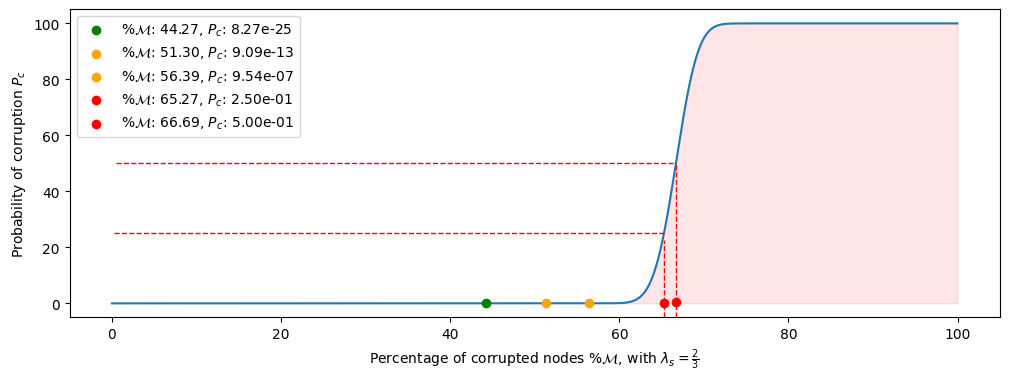

In [22]:
from matplotlib import pyplot as plt
import numpy as np

def malicious_majority_relative_malicious_share():
    xs = np.linspace(0, 100, 2**12, endpoint=False)
    ys = [100 * probge(512, 342, x/100) for x in xs]
    fig = plt.figure(figsize=(12, 4))
    plt.xlabel('Percentage of corrupted nodes $\%\mathcal{M}$, with $\lambda_s = \\frac{2}{3}$')
    plt.ylabel('Probability of corruption $P_c$')
    #plt.title('Probability of malicious majority relative to share of malicious validators')
    plt.plot(xs, ys)
    max_x = 60
    for (power, color) in [(80, 'green'), (40, 'orange'), (20, 'orange'), (2, 'red'), (1, 'red')]:
        y = [2**-power]
        x = 100 * safe_percentage_malicious_validators(2/3, y[0])
        print(x, y)
        plt.scatter([x], [y], c=color, zorder=3, label=f'$\%\mathcal{{M}}$: {x:.2f}, $P_c$: {y[0]:.2e}')
        plt.axvline(x=x, color=color, linestyle='--', linewidth=1, ymin=0, ymax=y[0], zorder=2)

        if color == 'red':
            intersection_y = ys[np.argmin(np.abs(xs - x))]  
            plt.hlines(y=intersection_y, xmin=y[0], xmax=x, color=color, linestyle='--', linewidth=1, zorder=2)
            min_x = min(max_x, x)

    if max_x > -1:
        ys_subset = np.array(ys)[np.array(xs) > min_x]
        xs_subset = np.array(xs)[np.array(xs) > min_x]
        plt.fill_between(xs_subset, 0, ys_subset, color='red', alpha=0.1)
        plt.legend()

    return fig

fig = malicious_majority_relative_malicious_share()
fig.savefig('../assets/malicious-corruption.png')
fig.show()

In [23]:
xs = np.linspace(2/3, .95, 512)
ys = []
count = 0
for kp in xs:
    value = 100 * safe_percentage_malicious_validators(kp)
    ys.append(value)
    count += 1
    if count % 50 == 0:
        print(f"count={count}")


count=50
count=100
count=150
count=200
count=250
count=300
count=350
count=400
count=450
count=500


90 71.44226294732397
70 47.69614602175382
80 58.745433714689234


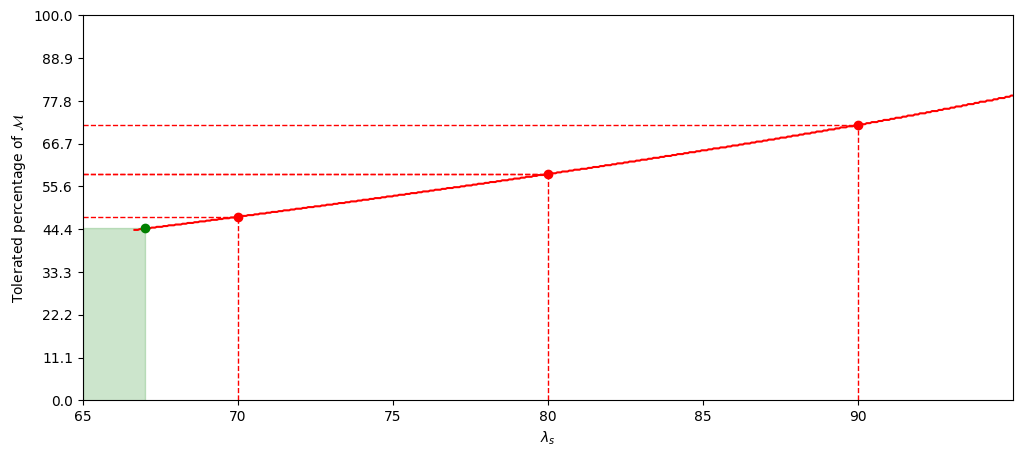

In [24]:

def malicious_share_delta():

    fig = plt.figure(figsize=(12, 5))
    plt.plot(xs * 100, ys, c="red")
    plt.xlabel('$\lambda_s}$')
    plt.xlim(65, 95)  # Manually set x-axis to go from 65 to 100.
    plt.ylim(0, 100)
    plt.xticks(np.arange(65, 95, 5))
    plt.ylabel('Tolerated percentage of $\mathcal{M}$')
    plt.yticks(np.linspace(0, 100, 10))

    # New points
    for power in [90, 70, 80]:
        y_value_at_power = ys[np.argmin(np.abs(xs * 100 - power))]  # find corresponding y-value at this power
        plt.scatter(power, y_value_at_power, c='red', zorder=3)
        plt.plot([power, power], [0, y_value_at_power], color='red', linestyle='--', linewidth=1)  # vertical line
        
        # Add a horizontal line from each point to xmin (let's say 65 in this case)
        plt.hlines(y=y_value_at_power, xmin=65, xmax=power, color='red', linestyle='--', linewidth=1, zorder=2)
        print(power, y_value_at_power)

    y_67 = ys[np.argmin(np.abs(xs *100 - 67))]
    plt.scatter(67, y_67, c='green', zorder=3)
    plt.hlines(y=y_value_at_power, xmin=65, xmax=power, color='red', linestyle='--', linewidth=1, zorder=2)
    plt.fill_between([65, 67], -5, y_67, color='green', alpha=0.2)
    #plt.title('Tolerated percentage of $\mathcal{M}$ as a function of $\lambda_s$')


    plt.show();
    return fig

fig_2 = malicious_share_delta()
fig_2.savefig('../assets/majority-safemal.png')